# Day 08. Exercise 01
# Binary classifier. SVM. Decision tree

## 0. Imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

## 1. Preprocessing and logreg visualization

Read the file `am_pm.csv` to a dataframe from the previous exercise.

1. Draw a plot where the x-axis is `am`, the y-axis is `pm`, dots are the days, color depends on the target.
2. Add the decision boundary of logistic regression to the plot.
3. Draw the same plot (with the boundary), but the color should depend this time on the predictions.

Now it should be clear for you how the logistic regression works.

In [5]:
df = pd.read_csv('../data/am_pm.csv')
df.head(5)

,date,target,AM,PM,predict
0,2020-04-17,working_day,21,2,weekend
1,2020-04-18,weekend,1,68,working_day
2,2020-04-19,weekend,18,15,working_day
3,2020-04-20,working_day,2,23,working_day
4,2020-04-21,working_day,0,25,working_day


In [6]:
X = df[['AM', 'PM']]
y = df['target']

logr = LogisticRegression(random_state=21, fit_intercept=False)
logr.fit(X, y)
logr.coef_[0]

array([-0.00038653,  0.00298066])

In [7]:
a = -logr.coef_[0][0] / logr.coef_[0][1]
b = -logr.intercept_[0] / logr.coef_[0][1]

xx = np.linspace(min(df['AM']), max(df['AM']))
yy = a * xx + b

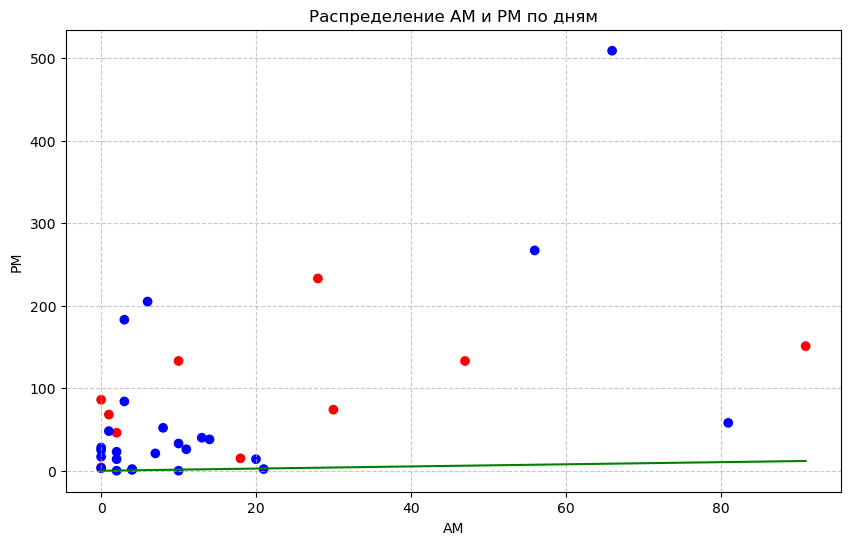

In [8]:
colors = {'working_day': 'blue', 'weekend': 'red'}
plt.figure(figsize=(10, 6))
plt.scatter(x=df['AM'], y=df['PM'], c=df['target'].map(colors))
plt.plot(xx, yy, color='green', label='Decision boundary')
plt.title('Распределение AM и PM по дням')
plt.xlabel('AM')
plt.ylabel('PM')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

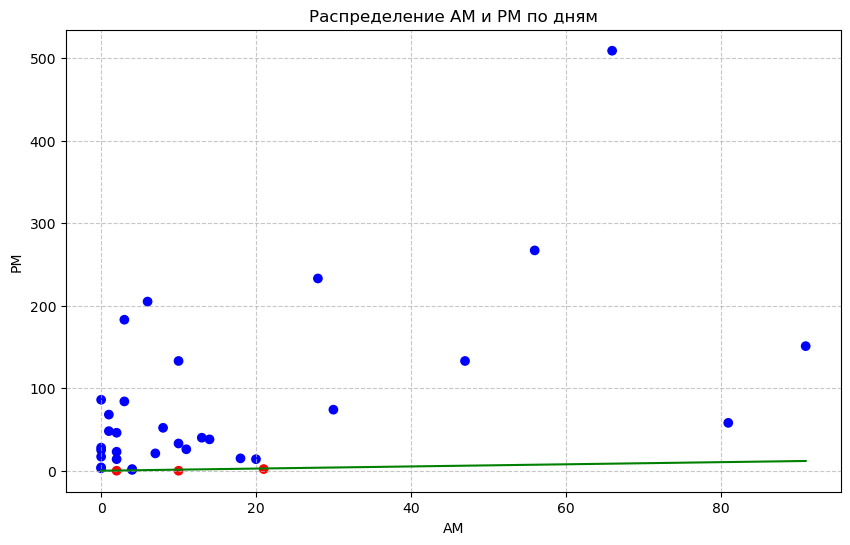

In [9]:
colors = {'working_day': 'blue', 'weekend': 'red'}
plt.figure(figsize=(10, 6))
plt.scatter(x=df['AM'], y=df['PM'], c=df['predict'].map(colors))
plt.plot(xx, yy, color='green', label='Decision boundary')
plt.title('Распределение AM и PM по дням')
plt.xlabel('AM')
plt.ylabel('PM')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 2. Standardizing and logreg

Linear models can be sensitive to the scale of your variables. You make it easier for them to find the optimal solution when you scale your features.

1. Apply `StandardScaler` to `X` and train logistic regression again with the same parameters.
2. Calculate `accuracy` for the new model. Did it get better than a naive classifier with the most popular class?
3. Draw the plots that were described above but for the new model.

In [10]:
df_scaler = df.copy()

scaler = StandardScaler()
df_scaler[['AM', 'PM']] = scaler.fit_transform(X)
df_scaler.head(5)

,date,target,AM,PM,predict
0,2020-04-17,working_day,0.200690,-0.719904,weekend
1,2020-04-18,weekend,-0.655914,-0.071822,working_day
2,2020-04-19,weekend,0.072199,-0.592251,working_day
3,2020-04-20,working_day,-0.613084,-0.513696,working_day
4,2020-04-21,working_day,-0.698744,-0.494057,working_day


In [11]:
X = df_scaler[['AM', 'PM']]
y = df_scaler['target']

logr.fit(X, y)
y_pred = logr.predict(X)
df_scaler['predict'] = y_pred

df_scaler.head(5)

,date,target,AM,PM,predict
0,2020-04-17,working_day,0.200690,-0.719904,working_day
1,2020-04-18,weekend,-0.655914,-0.071822,working_day
2,2020-04-19,weekend,0.072199,-0.592251,working_day
3,2020-04-20,working_day,-0.613084,-0.513696,working_day
4,2020-04-21,working_day,-0.698744,-0.494057,working_day


In [12]:
accuracy_score(df_scaler['target'], df_scaler['predict'])

0.7428571428571429

In [13]:
accuracy_score(y, [df['target'].mode().values] * len(y))

0.7142857142857143

In [14]:
a = -logr.coef_[0][0] / logr.coef_[0][1]
b = -logr.intercept_[0] / logr.coef_[0][1]

xx = np.linspace(min(df_scaler['AM']), max(df_scaler['AM']))
yy = a * xx + b

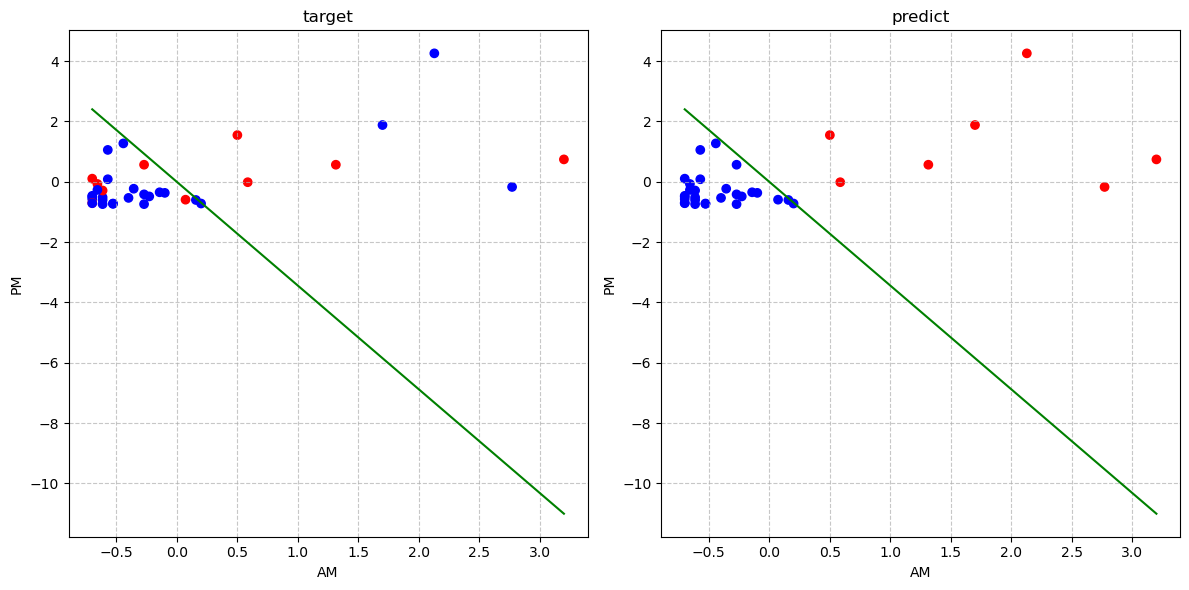

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
colors = {'working_day': 'blue', 'weekend': 'red'}

axs[0].scatter(x=df_scaler['AM'], y=df_scaler['PM'], c=df_scaler['target'].map(colors))
axs[0].plot(xx, yy, color='green', label='Decision boundary')
axs[0].set_title('target')
axs[0].set_xlabel('AM')
axs[0].set_ylabel('PM')
axs[0].grid(True, linestyle='--', alpha=0.7)

axs[1].scatter(x=df_scaler['AM'], y=df_scaler['PM'], c=df_scaler['predict'].map(colors))
axs[1].plot(xx, yy, color='green', label='Decision boundary')
axs[1].set_title('predict')
axs[1].set_xlabel('AM')
axs[1].set_ylabel('PM')
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

## 3. SVM

1. Apply `SVC` model to the scaled dataframe using parameters `probability=True`, `random_state=21`.
2. Calculate `accuracy`.
3. Try different kernels, find the best in terms of accuracy.
4. Draw both plots again with the decisions boundary to see how this algorithm works.

In [16]:
df_svc = df.copy()
df_svc.drop(columns='predict', inplace=True)
df_svc[['AM', 'PM']] = scaler.fit_transform(df[['AM', 'PM']])
df_svc['target'] = df_svc['target'].map({'working_day': 0, 'weekend': 1})
X = df_svc[['AM', 'PM']].values
y = df_svc['target'].values

In [17]:
def svc(X, y, kernel, df):
    model = SVC(kernel=kernel, random_state=21, probability=True).fit(X, y)
    y_pred = model.predict(X)
    df_svc[kernel] = y_pred
    score = accuracy_score(df_svc['target'], df_svc[kernel])
    print(f'kernel {kernel}: {score}')

In [18]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    svc(X, y, kernel, df_svc)

kernel linear: 0.7142857142857143
kernel poly: 0.7428571428571429
kernel rbf: 0.7428571428571429
kernel sigmoid: 0.6857142857142857


Best kernel: **'poly'**, score: 0.7428571428571429

In [19]:
svc = SVC(probability=True, random_state=21)
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
cv = GridSearchCV(svc, param_grid, scoring='accuracy')
cv.fit(X, y)
cv.best_params_

{'kernel': 'poly'}

In [20]:
df_svc.head(5)

,date,target,AM,PM,linear,poly,rbf,sigmoid
0,2020-04-17,0,0.200690,-0.719904,0,0,0,0
1,2020-04-18,1,-0.655914,-0.071822,0,0,0,0
2,2020-04-19,1,0.072199,-0.592251,0,0,0,0
3,2020-04-20,0,-0.613084,-0.513696,0,0,0,0
4,2020-04-21,0,-0.698744,-0.494057,0,0,0,0


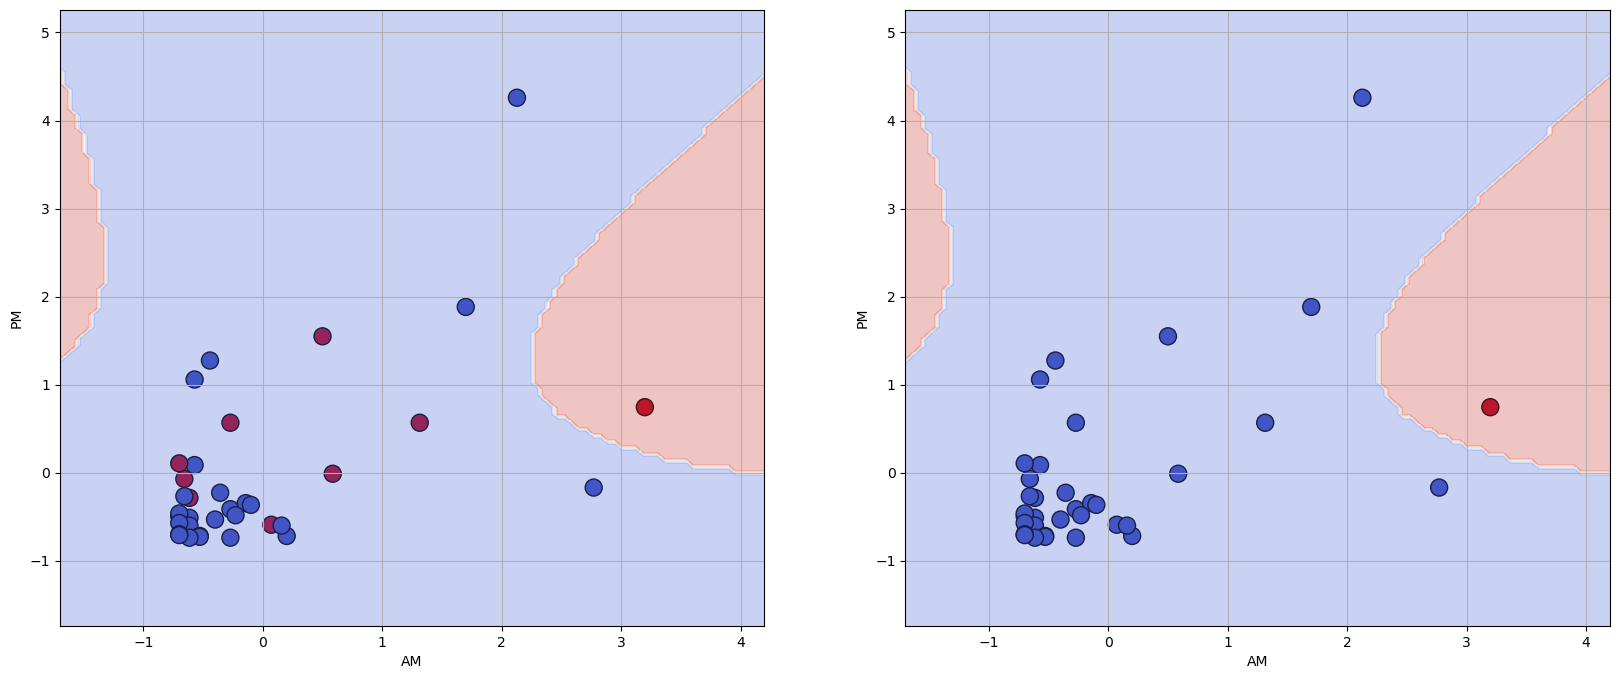

In [21]:
best_svc = SVC(kernel='poly', probability=True, random_state=21).fit(X, y)

# Определяем границы для графика
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Создание сетки
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Предсказываем классы для каждой точки в сетке
Z = best_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
colors = {'working_day': 'blue', 'weekend': 'red'}

ax[0].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm, s=150)
ax[0].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)  # Граница принятия решения

ax[0].set_xlabel('AM')
ax[0].set_ylabel('PM')
ax[0].grid()

ax[1].scatter(X[:, 0], X[:, 1], c=df_svc['poly'], edgecolors='k', cmap=plt.cm.coolwarm, s=150)
ax[1].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)  # Граница принятия решения

ax[1].set_xlabel('AM')
ax[1].set_ylabel('PM')
ax[1].grid()

plt.show()


## 4. Decision tree

1. Apply `DecisionTreeClassifier` to the scaled dataframe using parameters `max_depth=4`, `random_state=42`.
2. Calculate accuracy.
3. Try different values of `max_depth`.
4. Draw both plots again with the decisions boundary to see how this algorithm works.
5. Using method `.plot_tree()` visualize the decision tree itself. It is another way of thinking about how the algorithm works.
6. How many leaves in the visualized tree label days as working days? Put your answer in the markdown cell in the end of the section.

In [23]:
df_tree = df.copy()
df_tree.drop(columns='predict', inplace=True)
df_tree[['AM', 'PM']] = scaler.fit_transform(df[['AM', 'PM']])
df_tree['target'] = df_tree['target'].map({'working_day': 0, 'weekend': 1})
X = df_svc[['AM', 'PM']].values
y = df_svc['target'].values

In [31]:
for depth in range(1, 8):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X, y)
    y_pred = tree.predict(X)
    score = accuracy_score(y, y_pred)
    print(score)

0.7714285714285715
0.8571428571428571
0.8857142857142857
0.9428571428571428
0.9714285714285714
1.0
1.0


In [33]:
tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
param_grid = {'max_depth': range(1, 8)}
cv = GridSearchCV(tree, param_grid, scoring='accuracy')
cv.fit(X, y)
cv.best_params_

{'max_depth': 2}

In [35]:
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X, y)
y_pred = tree.predict(X)
df_tree['predict'] = y_pred
score = accuracy_score(y, y_pred)
print(score)

0.9428571428571428


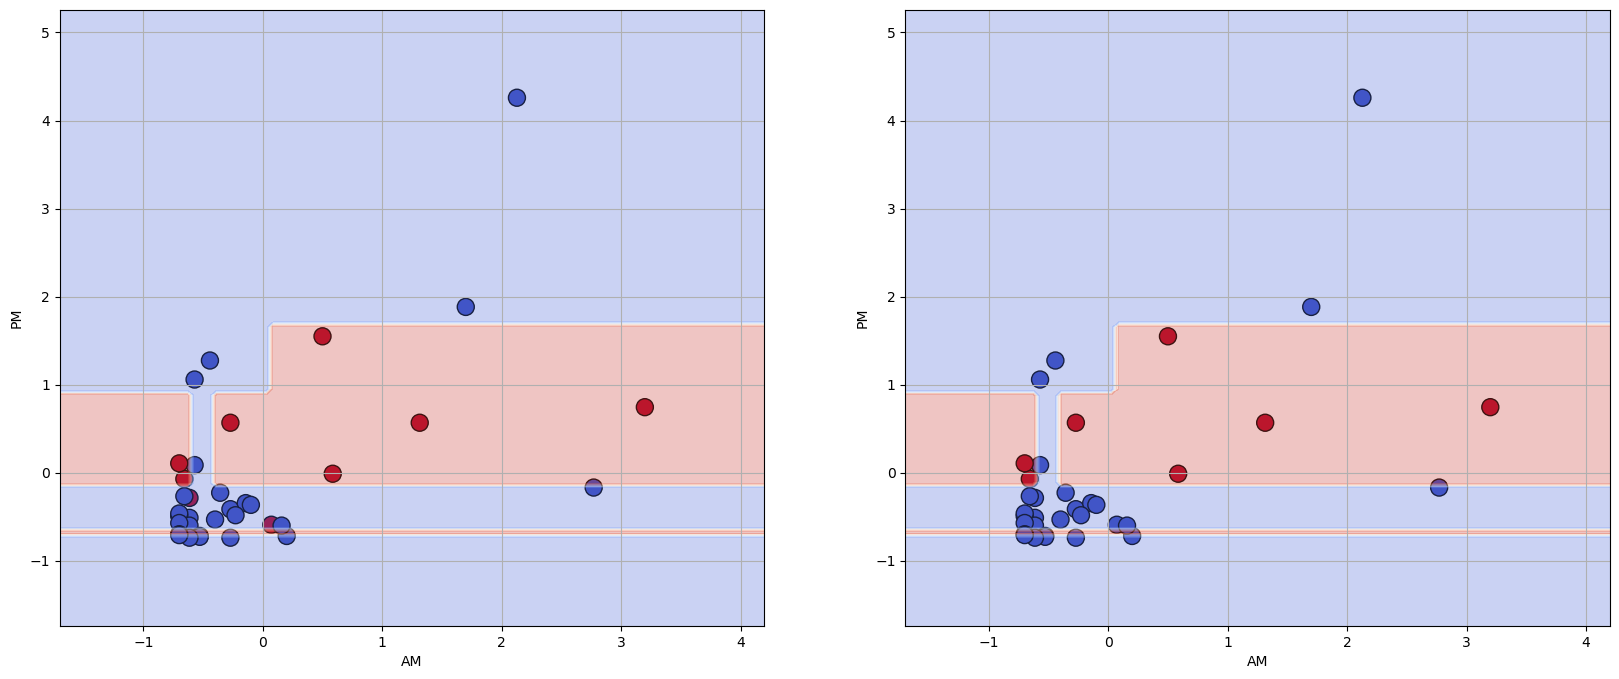

In [36]:
# Определяем границы для графика
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Создание сетки
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Предсказываем классы для каждой точки в сетке
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
colors = {'working_day': 'blue', 'weekend': 'red'}

ax[0].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm, s=150)
ax[0].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)  # Граница принятия решения

ax[0].set_xlabel('AM')
ax[0].set_ylabel('PM')
ax[0].grid()

ax[1].scatter(X[:, 0], X[:, 1], c=df_tree['predict'], edgecolors='k', cmap=plt.cm.coolwarm, s=150)
ax[1].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)  # Граница принятия решения

ax[1].set_xlabel('AM')
ax[1].set_ylabel('PM')
ax[1].grid()

plt.show()

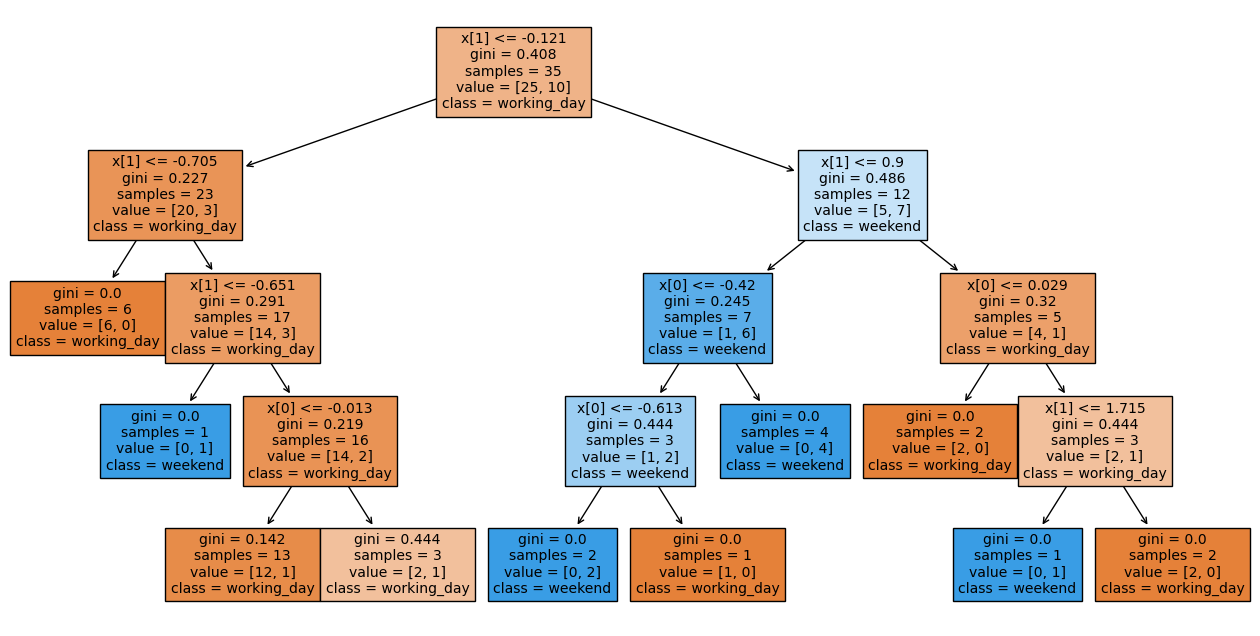

In [44]:
fig, ax = plt.subplots(figsize=(16, 8))

plot_tree(tree,
          class_names=['working_day', 'weekend'],
          filled=True, ax=ax)
plt.show()

**Answer:** working days 12 